<a href="https://colab.research.google.com/github/Sirsho1997/Book-Genre-Prediction-using-Book-Summary/blob/master/BookGenrePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The aim of this project is to apply the principles of text mining on a piece of literary text, and categorize it into the genre into which it best fits.**


At the very begining we have to **import all the necessary packages**.

In [0]:
#Importing libraries.

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


The dataset that have been used here is a subset of the **CMU Book Summary Dataset** available at http://www.cs.cmu.edu/~dbamman/booksummaries.html .
Dataset was unevenly distributed at the beginning. After days of data wrangling we could attain some uniformity in the dataset. The processed dataset has been uploaded as BookDataSet.csv , which has **6 main genres** - **"Crime Fiction", "Fanstasy", "Historical novel", "Horror", "Science Fiction", "Thriller"**.

**Load Data**

In [4]:
#Uploading the dataset on the google colab.
from google.colab import files
uploaded = files.upload()

Saving BooksDataSet.csv to BooksDataSet.csv


Creating the **books** dataframe.

In [0]:
#Using the pandas framework a dataset is created using the "BooksDataSet.csv" file.

books=pd.read_csv('BooksDataSet.csv')

#We only keep the 4 neccessary columns that we will be need. 
books=pd.DataFrame(books,columns=['book_id','book_name','genre','summary'])

Displaying the **books** dataframe.

In [6]:
#Display the books dataframe
print("Snapshot of books dataframe")
books

Snapshot of books dataframe


,book_id,book_name,genre,summary
0,3248537,Drowned Wednesday,Fantasy,Drowned Wednesday is the first Trustee among ...
1,27796919,The Lost Hero,Fantasy,"As the book opens, Jason awakens on a school ..."
2,3910776,The Eyes of the Overworld,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,5969644,Magic's Promise,Fantasy,The book opens with Herald-Mage Vanyel return...
4,3173445,Taran Wanderer,Fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...,...,...
2995,10372180,White Death,Thriller,"A Novel from the NUMA files, A Kurt Austin Ad..."
2996,14504372,Venus with Pistol,Thriller,Gilbert Kemp is dealer specializing in antiqu...
2997,3617412,Blackwater,Thriller,"""How do you know when you're in too deep? Dav..."
2998,11320975,The Rainbow and the Rose,Thriller,The story concerns the life of Johnnie Pascoe...


**Group our dataset by "genre"** and see that we have 500 rows dedicated to each of the 6 genres.

In [7]:
#Grouping all the rows by genre.


books.groupby('genre').count()

,book_id,book_name,summary
genre,,,
Crime Fiction,500,500,500
Fantasy,500,500,500
Historical novel,500,500,500
Horror,500,500,500
Science Fiction,500,500,500
Thriller,500,500,500


**Data pre-processing**

**Preprocessing the "summary"** column and making it ready for prediction.


*   At first the the "summary" is traversed and only the alphabets are kept while filtering out everything else and then the alphabets are converted into lowercase.

*   The most common words also known as stop words are removed.

*   Lemmatization is performed.

*   Stemming is performed.


**Step 1.** Filtering out any character which is not an alphabet and then converting each character into lowercase from column 'summary'

In [8]:
#Displaying "summary" before preprocessing begins.

print("Snapshot of books['summary']\n\n")
books['summary']

Snapshot of books['summary']




0        Drowned Wednesday is the first Trustee among ...
1        As the book opens, Jason awakens on a school ...
2        Cugel is easily persuaded by the merchant Fia...
3        The book opens with Herald-Mage Vanyel return...
4        Taran and Gurgi have returned to Caer Dallben...
                              ...                        
2995     A Novel from the NUMA files, A Kurt Austin Ad...
2996     Gilbert Kemp is dealer specializing in antiqu...
2997     "How do you know when you're in too deep? Dav...
2998     The story concerns the life of Johnnie Pascoe...
2999     The First Chief: Will Henry Lee: The novel op...
Name: summary, Length: 3000, dtype: object

In [0]:
# function for text cleaning
 
def clean(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

books.loc[:,'summary']=books.loc[:,'summary'].apply(lambda x: clean(x))


In [10]:
#Displaying "summary" after text-cleaning.

print("Snapshot of books['summary']\n\n")
books['summary']

Snapshot of books['summary']




0       drowned wednesday is the first trustee among t...
1       as the book opens jason awakens on a school bu...
2       cugel is easily persuaded by the merchant fian...
3       the book opens with herald mage vanyel returni...
4       taran and gurgi have returned to caer dallben ...
                              ...                        
2995    a novel from the numa files a kurt austin adve...
2996    gilbert kemp is dealer specializing in antique...
2997    how do you know when youre in too deep davey h...
2998    the story concerns the life of johnnie pascoe ...
2999    the first chief will henry lee the novel opens...
Name: summary, Length: 3000, dtype: object

The function **freqwords** will visualize the words and their frequency in a set of documents. It is used to find out the most frequent words in the book's summary:

Graph to visualize the words and frequency in book's summary.




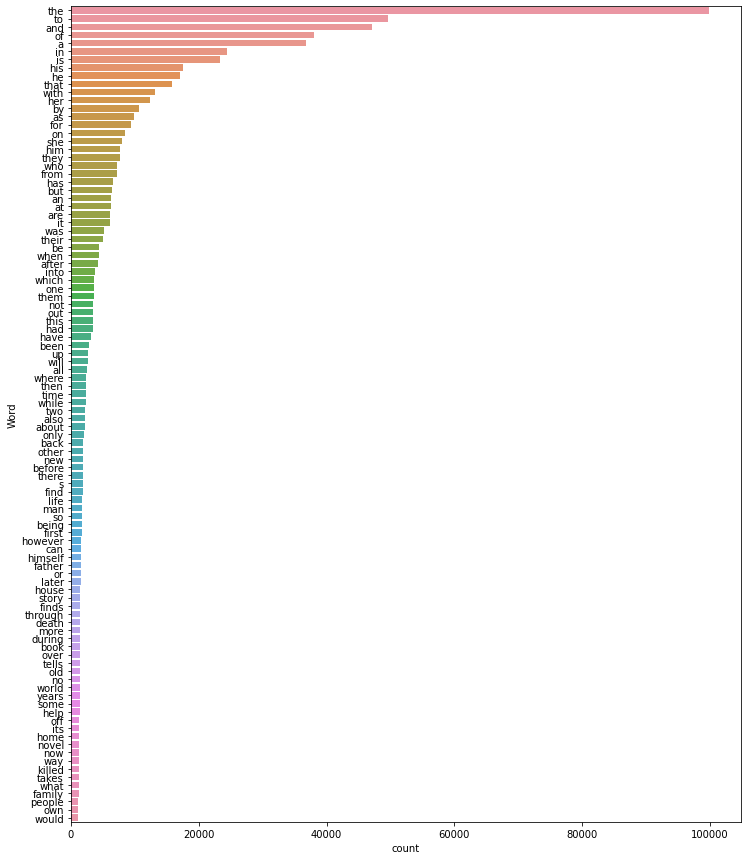

In [11]:
#Function to visualize the words and frequency in book's summary.

print("Graph to visualize the words and frequency in book's summary.\n\n")

def freqwords(x, terms): 
  allwords = ' '.join([text for text in x]) 
  allwords = allwords.split() 
  fdist = nltk.FreqDist(allwords) 
  wordsdf = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  
  d = wordsdf.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freqwords(books['summary'], 100)

**Step 2.** Removing stop words from the column "summary".

Another part of data cleaning is the **removal of stop words** – that is, common words like “the”, “a”, “an”. They are assumed to have no consequence over the classification process.

In [12]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def removestopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

books['summary'] = books['summary'].apply(lambda x: removestopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
#Displaying "summary" after removing stop words

print("Snapshot of books['summary']\n\n")

books['summary']

Snapshot of books['summary']




0       drowned wednesday first trustee among morrow d...
1       book opens jason awakens school bus unable rem...
2       cugel easily persuaded merchant fianosther att...
3       book opens herald mage vanyel returning countr...
4       taran gurgi returned caer dallben following ev...
                              ...                        
2995    novel numa files kurt austin adventure novel m...
2996    gilbert kemp dealer specializing antique guns ...
2997    know youre deep davey always lived shadow olde...
2998    story concerns life johnnie pascoe retired com...
2999    first chief henry lee novel opens growing town...
Name: summary, Length: 3000, dtype: object

3) **Lemmatization** on 'summary'

Greater the degree of randomness, greater would be the computation time, and lesser would be the efficiency of the detection of patterns in the textual corpora. We introduced the module which performs lemmatization on words, that is, **it groups different versions of the same word into one – for example, “do/doing/does/did”, “go/going/goes/went”** – so as to not let the algorithm treat similar words as different, and hence, make the analysis stronger.

In [14]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemma=WordNetLemmatizer()

def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


books['summary'] = books['summary'].apply(lambda x: lematizing(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [15]:
#Displaying "summary" after Lemmmatization

print("Snapshot of books['summary']\n\n")

books['summary']

Snapshot of books['summary']




0       drowned wednesday first trustee among morrow d...
1       book open jason awakens school bus unable reme...
2       cugel easily persuaded merchant fianosther att...
3       book open herald mage vanyel returning country...
4       taran gurgi returned caer dallben following ev...
                              ...                        
2995    novel numa file kurt austin adventure novel ma...
2996    gilbert kemp dealer specializing antique gun l...
2997    know youre deep davey always lived shadow olde...
2998    story concern life johnnie pascoe retired comm...
2999    first chief henry lee novel open growing town ...
Name: summary, Length: 3000, dtype: object

4) **Stemming** on 'summary'

**Stemming is the process of producing morphological variants of a root/base word.** Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces **the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”**.

In [0]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


books['summary'] = books['summary'].apply(lambda x: stemming(x))

In [17]:
#Displaying "summary" after Stemming

print("Snapshot of books['summary']\n\n")

books['summary']

Snapshot of books['summary']




0       drown wednesday first truste among morrow day ...
1       book open jason awaken school bu unabl rememb ...
2       cugel easili persuad merchant fianosth attempt...
3       book open herald mage vanyel return countri va...
4       taran gurgi return caer dallben follow event t...
                              ...                        
2995    novel numa file kurt austin adventur novel mai...
2996    gilbert kemp dealer special antiqu gun london ...
2997    know your deep davey alway live shadow older b...
2998    stori concern life johnni pasco retir commerci...
2999    first chief henri lee novel open grow town del...
Name: summary, Length: 3000, dtype: object

Visualizing  the words in book's summary once again after successfully pre-processing.

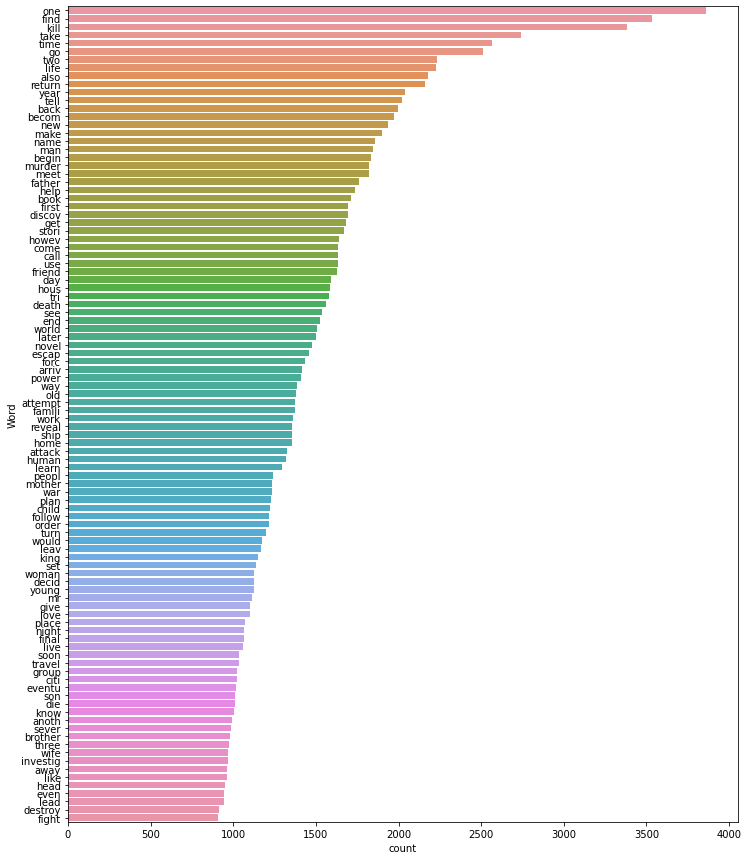

In [18]:
#Function to visualize the words and frequency in book's summary.


# print 100 most frequent words 
freqwords(books['summary'], 100)

**Converting Text in Books dataset to Features**

Now, we **denote an unique number to each of the 6 genres** from 0 - 5

In [0]:
#Labeling each 'genre' with an unique number 

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

y=LE.fit_transform(books['genre'])


The mapping is 1:1

**Crime Fiction    -  0**

**Fantasy          -  1**

**Historical novel -  2**

**Horror           -  3**

**Science Fiction  -  4**

**Thriller         -  5** 

In [20]:
#perform inverse mapping on the unique numbers representing a genre.



LE.inverse_transform([0,1,2,3,4,5])

array(['Crime Fiction', 'Fantasy', 'Historical novel', 'Horror',
       'Science Fiction', 'Thriller'], dtype=object)

**Fitting the models**

**1.** At first a **80-20% split** was performed on the dataset

In [0]:
xtrain, xval, ytrain, yval = train_test_split(books['summary'], y, test_size=0.2, random_state=557) 

**tf-idf was performed on "summary" for both train(i.e xtrain) and test(i.e xval).**

**tf–idf** or TFIDF, short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.


**tf(t)** = (Number of times term t appears in a document) / (Total number of terms in the document).

**idf(t)** = log_e(Total number of documents / Number of documents with term t in it).

In [0]:
#Performing tf-idf 

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain.values.astype('U'))

xval_tfidf = tfidf_vectorizer.transform(xval.values.astype('U'))


**Using Logistic Regression**

Logistic Regression is used when the **dependent variable( target ) is categorical**.

logistic regressions are only binary classifiers, meaning they cannot handle target vectors with more than two classes. However, there are clever extensions to logistic regression to do just that. In one-vs-rest logistic regression (OVR) a separate model is trained for each class predicted whether an observation is that class or not (thus making it a binary classification problem). It assumes that each classification problem (e.g. class 0 or not) is independent.

In [23]:

start=datetime.now()

from sklearn.linear_model import LogisticRegression

# Binary Relevance.
from sklearn.multiclass import OneVsRestClassifier

# Performance metric.
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data.
clf.fit(xtrain_tfidf, ytrain)

# make predictions for validation set.
y_pred_lr = clf.predict(xval_tfidf)


from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(yval,y_pred_lr) )

#Printing the classification report.
print ('Report : ')
print(classification_report(yval,y_pred_lr))

print("Executed in ",datetime.now()-start)

Accuracy Score : 0.785
Report : 
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       102
           1       0.69      0.78      0.73        89
           2       0.83      0.86      0.84       110
           3       0.80      0.73      0.76       100
           4       0.82      0.80      0.81        97
           5       0.78      0.71      0.74       102

    accuracy                           0.79       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.79      0.79      0.78       600

Executed in  0:00:00.715890


**Using SVM**

 SVMs try to find a separating line(or hyperplane) between data of two classes. SVM is an algorithm that takes the data as an input and outputs a line that separates those classes if possible.

 According to the SVM algorithm we find the points closest to the line from both the classes.These points are called support vectors. Now, we compute the distance between the line and the support vectors. This distance is called the margin. Our goal is to maximize the margin. The hyperplane for which the margin is maximum is the optimal hyperplane.

 Thus SVM tries to make a decision boundary in such a way that the separation between the two classes(that street) is as wide as possible.


 The linear, polynomial and RBF or Gaussian kernel are simply different in case of making the hyperplane decision boundary between the classes.
The kernel functions are used to map the original dataset (linear/nonlinear ) into a higher dimensional space with view to making it linear dataset.

Usually linear and polynomial kernels are less time consuming and provides less accuracy than the rbf or Gaussian kernels.

**--SVM('linear')--**

In [24]:
start=datetime.now()

from sklearn import svm

svc = svm.SVC(kernel='linear').fit(xtrain_tfidf,ytrain)

svpred=svc.predict(xval_tfidf)

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  


print( 'Accuracy Score :',accuracy_score(yval,svpred) )
print ('Report : ')
print(classification_report(yval,svpred))

print("Executed in ",datetime.now()-start)

Accuracy Score : 0.7633333333333333
Report : 
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       102
           1       0.69      0.72      0.70        89
           2       0.81      0.87      0.84       110
           3       0.74      0.73      0.73       100
           4       0.79      0.75      0.77        97
           5       0.73      0.70      0.71       102

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

Executed in  0:00:12.215113


**--SVM(kernel=rbf)--**

In [25]:
start=datetime.now()

from sklearn import svm

svc = svm.SVC(kernel='rbf',gamma=1).fit(xtrain_tfidf,ytrain)

svpred=svc.predict(xval_tfidf)

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  


print( 'Accuracy Score :',accuracy_score(yval,svpred) )
print ('Report : ')
print(classification_report(yval,svpred))

print("Executed in ",datetime.now()-start)

Accuracy Score : 0.775
Report : 
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       102
           1       0.67      0.76      0.71        89
           2       0.84      0.85      0.84       110
           3       0.77      0.72      0.74       100
           4       0.83      0.77      0.80        97
           5       0.71      0.75      0.73       102

    accuracy                           0.78       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.78      0.78      0.78       600

Executed in  0:00:13.221253


**2.** Next a **85-15% split** was performed on the dataset

In [0]:
xtrain, xval, ytrain, yval = train_test_split(books['summary'], y, test_size=0.15, random_state=246) 

**tf-idf was performed on "summary" for both train(i.e xtrain) and test(i.e xval).**


In [0]:
#Performing tf-idf 

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain.values.astype('U'))

xval_tfidf = tfidf_vectorizer.transform(xval.values.astype('U'))


**Using Logistic Regression**


In [28]:
start=datetime.now()

from sklearn.linear_model import LogisticRegression

# Binary Relevance.
from sklearn.multiclass import OneVsRestClassifier

# Performance metric.
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data.
clf.fit(xtrain_tfidf, ytrain)

# make predictions for validation set.
y_pred_lr = clf.predict(xval_tfidf)


from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(yval,y_pred_lr) )

#Printing the classification report.
print ('Report : ')
print(classification_report(yval,y_pred_lr))

print("Executed in ",datetime.now()-start)

Accuracy Score : 0.7844444444444445
Report : 
              precision    recall  f1-score   support

           0       0.73      0.78      0.75        67
           1       0.80      0.83      0.81        82
           2       0.85      0.85      0.85        86
           3       0.74      0.74      0.74        72
           4       0.82      0.86      0.84        64
           5       0.75      0.66      0.70        79

    accuracy                           0.78       450
   macro avg       0.78      0.78      0.78       450
weighted avg       0.78      0.78      0.78       450

Executed in  0:00:00.685264


**Using SVM**


**--SVM('linear')--**

In [29]:
start=datetime.now()

from sklearn import svm

svc = svm.SVC(kernel='linear').fit(xtrain_tfidf,ytrain)

svpred=svc.predict(xval_tfidf)

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  


print( 'Accuracy Score :',accuracy_score(yval,svpred) )
print ('Report : ')
print(classification_report(yval,svpred))

print("Executed in ",datetime.now()-start)

Accuracy Score : 0.7822222222222223
Report : 
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        67
           1       0.78      0.84      0.81        82
           2       0.86      0.84      0.85        86
           3       0.70      0.75      0.72        72
           4       0.84      0.83      0.83        64
           5       0.74      0.70      0.72        79

    accuracy                           0.78       450
   macro avg       0.78      0.78      0.78       450
weighted avg       0.78      0.78      0.78       450

Executed in  0:00:13.150380


**--SVM(kernel=rbf)--**

In [30]:
start=datetime.now()

from sklearn import svm

svc = svm.SVC(kernel='rbf',gamma=1).fit(xtrain_tfidf,ytrain)

svpred=svc.predict(xval_tfidf)

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  


print( 'Accuracy Score :',accuracy_score(yval,svpred) )
print ('Report : ')
print(classification_report(yval,svpred))

print("Executed in ",datetime.now()-start)

Accuracy Score : 0.7955555555555556
Report : 
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        67
           1       0.80      0.88      0.84        82
           2       0.87      0.85      0.86        86
           3       0.73      0.75      0.74        72
           4       0.86      0.86      0.86        64
           5       0.74      0.68      0.71        79

    accuracy                           0.80       450
   macro avg       0.79      0.79      0.79       450
weighted avg       0.80      0.80      0.79       450

Executed in  0:00:14.350671


Thus we conclude that **highest accuracy** was obtained during a **85-15% split** while using a **svm with rbf as the kernel function.**

The highest **accuracy is 79.55 %**

Now, we **build an inference function for predicting the genres of new books in the future.**

Our book genre prediction system should be able to take a book's summary in raw form as input and generate its genre tag.

To achieve this the steps to be considered during building the function are -

*   Clean the texts.
*   Remove stopwords from the cleaned texts.
*   Perform Lemmatization.
*   Perform Stemming.
*   Extract features from the text.
*   Make predictions using svm with rbf as the kernel function.
*   Return the predicted book genre tag.



**Executing the inference function on SVM(kernel=rbf) to predict future unknown genre**

In [32]:
start=datetime.now()

def infertag(q):
    q = clean(q)
    q = removestopwords(q)
    q = lematizing(q)
    q = stemming(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = svc.predict(q_vec)
    return LE.inverse_transform(q_pred)[0]
    #return q_pred[0]


for i in range(50): 
  k = xval.sample(1).index[0] 
  print("Book: ", books['book_name'][k], "\nPredicted genre: ", infertag(xval[k]),"\nActual genre: ",books['genre'][k], "\n")

print("Executed in ",datetime.now()-start)

Book:  The Mislaid Charm 
Predicted genre:  Fantasy 
Actual genre:  Fantasy 

Book:  To Reign in Hell: The Exile of Khan Noonien Singh 
Predicted genre:  Science Fiction 
Actual genre:  Science Fiction 

Book:  Beyond This Place 
Predicted genre:  Horror 
Actual genre:  Thriller 

Book:  The Seekers 
Predicted genre:  Historical novel 
Actual genre:  Historical novel 

Book:  The Collector 
Predicted genre:  Science Fiction 
Actual genre:  Horror 

Book:  This Perfect Day 
Predicted genre:  Science Fiction 
Actual genre:  Horror 

Book:  The Excalibur Alternative 
Predicted genre:  Science Fiction 
Actual genre:  Science Fiction 

Book:  Invaders from the Dark 
Predicted genre:  Horror 
Actual genre:  Horror 

Book:  Parasite Eve 
Predicted genre:  Science Fiction 
Actual genre:  Horror 

Book:  Blind Justice 
Predicted genre:  Historical novel 
Actual genre:  Historical novel 

Book:  Tyrannosaur Canyon 
Predicted genre:  Thriller 
Actual genre:  Thriller 

Book:  Angel Rock 
Predicte